# cs231n Two-Layer Backprop Mathematics Example
In this notebook I attempt to connect the mathematics of backprop to the variables and network from the Two-Layer Neural Network assigment supplied here: http://cs231n.stanford.edu/assignments/2017/spring1617_assignment1.zip. Each significant variable has a section explaining the math used to calculate the variable's content in the case where the network has the following starting conditions:

$$\begin{align*}
\mathit{X} &= \begin{bmatrix}16 & -6\end{bmatrix} &
\mathit{y} &= 2 \\
\mathit{W1} &= \begin{bmatrix}0.18 & 0.04 \\ 0.1 & 0.22\end{bmatrix} &
\mathit{b1} &= \begin{bmatrix}0 & 0\end{bmatrix} \\
\mathit{W2} &= \begin{bmatrix}0.19 & -0.1 & 0.1 \\ -0.02 & -0.01 & 0.04\end{bmatrix} &
\mathit{b2} &= \begin{bmatrix}0 & 0 & 0\end{bmatrix}
\end{align*}$$

I'll also check the calculations when possible with a completed `cs231n/classifiers/neural_net.py` that has the starting conditions hardcoded. 

A description of the network can be found here https://cs231n.github.io/neural-networks-case-study/#net although the variable names don't exactly match the assignment (I'm pretty sure you can figure out what's what). This diagram of the network may also help with intuitive understanding (gradients are in dark red):
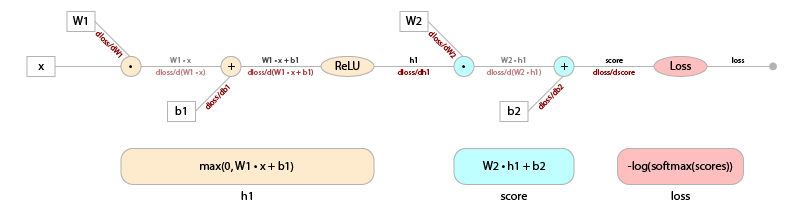

**Sections**
- [Forward Pass](#fp)
    - [h1](#h1)
    - [scores](#scores)
    - [loss](#loss)
- [Backward Pass](#bp)
    - [dscores](#dscores)
    - [grads\['W2'\]](#dW2)
    - [grads\['b2'\]](#db2)
    - [dh1](#dh1)
    - [dh1\[h1 <= 0\] = 0](#dh1_1)
    - [grads\['W1'\]](#dW1)
    - [grads\['b1'\]](#db1)

Notes
- indexing subscripts may either start at 0 or 1, I need to fix this
- dW1 and db1 aren't finished
- There's some steps where I think the multivariable chain rule is required but it seems obvious the partial derivatives are 0 so I skip them. At least that's what I think is going on. For example (fixed the indexing to start at 1 here):

$$\begin{align}
\frac{\partial{loss}}{\partial{\mathit{W2_{11}}}}
&= \frac{\partial{loss}}{\partial{scores}} \frac{\partial{scores}}{\partial{\mathit{W2_{11}}}} \\
&= \frac{\partial{loss}}{\partial{scores_1}} \frac{\partial{scores_1}}{\partial{\mathit{W2_{11}}}} +
\frac{\partial{loss}}{\partial{scores_2}} \frac{\partial{scores_2}}{\partial{\mathit{W2_{11}}}} +
\frac{\partial{loss}}{\partial{scores_3}} \frac{\partial{scores_3}}{\partial{\mathit{W2_{11}}}} \\
&= \frac{\partial{loss}}{\partial{scores_1}} \frac{\partial{scores_1}}{\partial{\mathit{W2_{11}}}} + 0 + 0\\
&= \frac{\partial{loss}}{\partial{scores_1}} \frac{\partial{scores_1}}{\partial{\mathit{W2_{11}}}}
\end{align}$$

In [38]:
# A bit of setup
import numpy as np
# I hard coded the starting conditions in a completed neural_net.py and renamed it backprop_math_neural_net.py
from cs231n.classifiers.backprop_math_neural_net import TwoLayerNet
from __future__ import print_function

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# if we were doing a random initialization for this example,
# these would be the arguments
input_size = 2
hidden_size = 2
num_classes = 3

# however, since the starting conditions are hard coded the arguments don't matter much
net = TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)
X = np.array([[16., -6.]])
y = np.array([2])

# these values should match the starting conditions
print("X:\n", X, "\ny:\n", y)
for k in net.params:
    print(k, ":\n", net.params[k], sep='')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X:
 [[16. -6.]] 
y:
 [2]
W1:
[[0.18 0.04]
 [0.1  0.22]]
b1:
[0. 0.]
W2:
[[ 0.19 -0.1   0.1 ]
 [-0.02 -0.01  0.04]]
b2:
[0. 0. 0.]


## Forward Pass <a id='fp'></a>
***
`h1` <a id='h1'></a>

$\mathit{h1} = 
\max(0, \mathit{X} \mathit{W1} + \mathit{b1}) = 
\max (0, \begin{bmatrix}16 & -6\end{bmatrix} \begin{bmatrix}0.18 & 0.04 \\ 0.1 & 0.22\end{bmatrix} + \begin{bmatrix}0 & 0\end{bmatrix}) = 
\max (0, \begin{bmatrix}2.28 & -0.68\end{bmatrix}) = 
\begin{bmatrix}2.28 & 0\end{bmatrix}$

***
`scores` <a id='scores'></a>

$\mathit{scores} = 
\mathit{h1} \mathit{W2} + \mathit{b2} = 
\begin{bmatrix}2.28 & 0\end{bmatrix} \begin{bmatrix}0.19 & -0.1 & 0.1 \\ -0.02 & -0.01 & 0.04\end{bmatrix} + \begin{bmatrix}0. & 0. & 0.\end{bmatrix} = 
\begin{bmatrix}0.4332 & -0.228 & 0.228\end{bmatrix}$

In [4]:
# Check that the math matches the network
math_scores = np.asarray([[0.4332, -0.228, 0.228]])
scores = net.loss(X)
print('Network scores:')
print(scores)
print()

print('Math scores:')
print(math_scores)
print()

print('Difference between network scores and math scores:')
print(np.sum(np.abs(scores - math_scores)))

Network scores:
[[ 0.4332 -0.228   0.228 ]]

Math scores:
[[ 0.4332 -0.228   0.228 ]]

Difference between network scores and math scores:
5.551115123125783e-17


***
`loss` <a id='loss'></a>

We want the true probabilities for each class. Since $y = 2$, we one hot encode to get
$trueprob = \begin{bmatrix}0 & 0 & 1\end{bmatrix}$. Then

$$\begin{align}
loss &= -(trueprob_0) \log{(\frac{e^{scores_0}}{e^{scores_0} + e^{scores_1} + e^{scores_2}})} \\
&+ -(trueprob_1)\log{(\frac{e^{scores_1}}{e^{scores_0} + e^{scores_1} + e^{scores_2}})} \\ 
&+ -(trueprob_2)\log{(\frac{e^{scores_2}}{e^{scores_0} + e^{scores_1} + e^{scores_2}})} \\
&= -(0)\log{(\frac{e^{0.4332}}{e^{0.4332} + e^{-0.228} + e^{0.228}})} \\
&+ -(0)\log{(\frac{e^{-0.228}}{e^{0.4332} + e^{-0.228} + e^{0.228}})} \\
&+ -(1)\log{(\frac{e^{0.228}}{e^{0.4332} + e^{-0.228} + e^{0.228}})} \\
&= 1.051375468504
\end{align}$$

In [28]:
# Check that the math matches the network
math_loss = 1.051375468504
loss, grad = net.loss(X, y)
print('Network loss:')
print(loss)
print()

print('Math loss:')
print(math_loss)
print()

print('Difference between network loss and math loss:')
print(np.sum(np.abs(loss - math_loss)))

Network loss:
1.0513754685043635

Math loss:
1.051375468504

Difference between network loss and math loss:
3.6348701826227625e-13


## Backward Pass <a id='bp'></a>
***
`dscores` <a id='dscores'></a>

To start, we want to find $\nabla loss = \begin{bmatrix}\frac{\partial{loss}}{\partial{scores_0}} & \frac{\partial{loss}}{\partial{scores_1}}  & \frac{\partial{loss}}{\partial{scores_2}}\end{bmatrix}$ where $loss$ is a function of $scores$.
Note that $-scores_y + \log \sum\limits_{j} e^{scores_j}$ is an alternate form of the loss function that is easier to differentiate with respect to $scores_j$. Remembering that in this case $y = 2$, we get

$$\begin{align}
\frac{\partial{loss}}{\partial{scores_0}} 
&= \frac{\partial}{\partial{scores_0}}(-scores_2 + \log{(e^{scores_0} + e^{scores_1} + e^{scores_2})}) \\
&= 0 + \frac{e^{scores_0}}{(e^{scores_0} + e^{scores_1} + e^{scores_2})} \\
&= \text{softmax}(scores_0), \\
\frac{\partial{loss}}{\partial{scores_1}} 
&= \frac{\partial}{\partial{scores_1}}(-scores_2 + \log{(e^{scores_0} + e^{scores_1} + e^{scores_2})}) \\
&= 0 + \frac{e^{scores_1}}{(e^{scores_0} + e^{scores_1} + e^{scores_2})} \\
&= \text{softmax}(scores_1), \\
\frac{\partial{loss}}{\partial{scores_2}} 
&= \frac{\partial}{\partial{scores_2}}(-scores_2 + \log{(e^{scores_0} + e^{scores_1} + e^{scores_2})}) \\
&= -1 + \frac{e^{scores_2}}{(e^{scores_0} + e^{scores_1} + e^{scores_2})} \\
&= -1 + \text{softmax}(scores_2). \\
\end{align}$$

Next, we evaluate $\nabla loss(scores)$ at the scores from our forward pass. Recall that $\mathit{scores} = \begin{bmatrix}0.4332 & -0.228 & 0.228\end{bmatrix}$, so

$$\begin{align}
\nabla loss(scores) &= \begin{bmatrix}\text{softmax}(scores_0) & \text{softmax}(scores_1) & -1 + \text{softmax}(scores_2)\end{bmatrix} \\
&= \begin{bmatrix}\text{softmax}(0.4332) & \text{softmax}(-0.228) & -1 + \text{softmax}(0.228)\end{bmatrix} \\
&= \begin{bmatrix}0.429052723714 & 0.221490524653 & -0.650543248367\end{bmatrix}.
\end{align}$$ 

This is the array stored in the variable `dscores`.

***
`grad['W2']` <a id='dW2'></a>

We want to find
$
\frac{\partial{loss}}{\partial{\mathit{W2}}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{\mathit{W2_{11}}}} &
\frac{\partial{loss}}{\partial{\mathit{W2_{12}}}} &
\frac{\partial{loss}}{\partial{\mathit{W2_{13}}}} \\
\frac{\partial{loss}}{\partial{\mathit{W2_{21}}}} &
\frac{\partial{loss}}{\partial{\mathit{W2_{22}}}} &
\frac{\partial{loss}}{\partial{\mathit{W2_{23}}}}
\end{bmatrix}.
$
Note that

$$\begin{align}
\frac{\partial{loss}}{\partial{\mathit{W2_{11}}}}
&= \frac{\partial{loss}}{\partial{scores_0}} \frac{\partial{scores_0}}{\partial{\mathit{W2_{11}}}} \\
&= \frac{\partial{loss}}{\partial{scores_0}} \frac{\partial{}}{\partial{\mathit{W2_{11}}}}(\mathit{h1_1} \mathit{W2_{11}} + \mathit{h1_2} \mathit{W2_{21}} + \mathit{b2_1}) \\
&= \frac{\partial{loss}}{\partial{scores_0}}(\mathit{h1_1}).
\end{align}$$

If we apply similar logic to every element of $\frac{\partial{loss}}{\partial{\mathit{W2}}}$ we get

$$\begin{align}
\frac{\partial{loss}}{\partial{\mathit{W2}}} 
&= 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{scores_0}}(\mathit{h1_1}) &
\frac{\partial{loss}}{\partial{scores_1}}(\mathit{h1_1}) &
\frac{\partial{loss}}{\partial{scores_2}}(\mathit{h1_1}) \\
\frac{\partial{loss}}{\partial{scores_0}}(\mathit{h1_2}) &
\frac{\partial{loss}}{\partial{scores_1}}(\mathit{h1_2}) &
\frac{\partial{loss}}{\partial{scores_2}}(\mathit{h1_2})
\end{bmatrix} \\
&= \begin{bmatrix} \mathit{h1_1} \\ \mathit{h1_2} \end{bmatrix} 
\begin{bmatrix} \frac{\partial{loss}}{\partial{scores_0}} & \frac{\partial{loss}}{\partial{scores_1}} & \frac{\partial{loss}}{\partial{scores_2}} \end{bmatrix} \\
&= \mathit{h1}^\mathsf{T} \nabla loss.
\end{align}$$

So the array stored in `grad['W2']` is

$$\begin{align}
\mathit{h1}^\mathsf{T} \nabla loss(scores)
&= \begin{bmatrix}2.28 \\ 0\end{bmatrix} \begin{bmatrix}0.429052723714 & 0.221490524653 & -0.650543248367\end{bmatrix} \\
&= \begin{bmatrix}
0.978240210068 & 0.504998396209 & -1.483238606277 \\
0 & 0 & 0
\end{bmatrix}.
\end{align}$$

In [29]:
# Check that the math matches the network
math_dW2 = np.asarray([[0.978240210068 , 0.504998396209 , -1.483238606277], [0, 0, 0]])
print('Network dW2:')
print(grad['W2'])
print()

print('Math dW2:')
print(math_dW2)
print()

print('Difference between network loss and math loss:')
print(np.sum(np.abs(grad['W2'] - math_dW2)))

Network dW2:
[[ 0.97824021  0.5049984  -1.48323861]
 [ 0.          0.          0.        ]]

Math dW2:
[[ 0.97824021  0.5049984  -1.48323861]
 [ 0.          0.          0.        ]]

Difference between network loss and math loss:
2.4562574196806963e-12


***
`grad['b2']` <a id='db2'></a>

We want to find
$
\frac{\partial{loss}}{\partial{\mathit{b2}}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{\mathit{b2_{0}}}} &
\frac{\partial{loss}}{\partial{\mathit{b2_{1}}}} &
\frac{\partial{loss}}{\partial{\mathit{b2_{2}}}} 
\end{bmatrix}.
$
Note that

$$\begin{align}
\frac{\partial{loss}}{\partial{\mathit{b2_{0}}}}
&= \frac{\partial{loss}}{\partial{scores_0}} \frac{\partial{scores_0}}{\partial{\mathit{b2_{0}}}} \\
&= \frac{\partial{loss}}{\partial{scores_0}} \frac{\partial{}}{\partial{\mathit{b2_{0}}}}(\mathit{h1_1} \mathit{W2_{11}} + \mathit{h1_2} \mathit{W2_{21}} + \mathit{b2_0}) \\
&= \frac{\partial{loss}}{\partial{scores_0}}(1).
\end{align}$$

If we apply similar logic to every element of $\frac{\partial{loss}}{\partial{\mathit{b2}}}$ we get
$\frac{\partial{loss}}{\partial{\mathit{b2}}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{scores_0}} &
\frac{\partial{loss}}{\partial{scores_1}} &
\frac{\partial{loss}}{\partial{scores_2}}
\end{bmatrix}
= \nabla loss(scores).$

So the array stored in `grad['b2']` is
$\nabla loss(scores) = \begin{bmatrix}0.429052723714 & 0.221490524653 & -0.650543248367\end{bmatrix}.$

In [30]:
math_db2 = np.asarray([0.429052723714 , 0.221490524653 , -0.650543248367])
print('Network db2:')
print(grad['b2'])
print()

print('Math db2:')
print(math_db2)
print()

print('Difference between network loss and math loss:')
print(np.sum(np.abs(grad['b2'] - math_db2)))

Network db2:
[ 0.42905272  0.22149052 -0.65054325]

Math db2:
[ 0.42905272  0.22149052 -0.65054325]

Difference between network loss and math loss:
9.368616993299383e-13


***
`dh1`  <a id='dh1'></a>

We want to find
$
\frac{\partial{loss}}{\partial{\mathit{h1}}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{\mathit{h1_{1}}}} &
\frac{\partial{loss}}{\partial{\mathit{h1_{2}}}}
\end{bmatrix}.
$
By the multivariable chain rule

$$\begin{align}
\frac{d{loss}}{d{\mathit{h1_1}}} 
&= \frac{\partial{loss}}{\partial{scores_0}} \frac{d{scores_0}}{d{\mathit{h1_1}}} +
\frac{\partial{loss}}{\partial{scores_1}} \frac{d{scores_1}}{d{\mathit{h1_1}}} +
\frac{\partial{loss}}{\partial{scores_2}} \frac{d{scores_2}}{d{\mathit{h1_1}}} \\
&= \frac{\partial{loss}}{\partial{scores_0}} \frac{d{}}{d{\mathit{h1_1}}}(\mathit{h1_1} \mathit{W2_{11}} + \mathit{h1_2} \mathit{W2_{21}} + \mathit{b2_0}) +
\frac{\partial{loss}}{\partial{scores_1}} \frac{d{}}{d{\mathit{h1}}}(\mathit{h1_1} \mathit{W2_{12}} + \mathit{h1_2} \mathit{W2_{22}} + \mathit{b2_1}) +
\frac{\partial{loss}}{\partial{scores_2}} \frac{d{}}{d{\mathit{h1}}}(\mathit{h1_1} \mathit{W2_{13}} + \mathit{h1_2} \mathit{W2_{23}} + \mathit{b2_2}) \\
&= \frac{\partial{loss}}{\partial{scores_0}} (\mathit{W2}_{11}) +
\frac{\partial{loss}}{\partial{scores_1}} (\mathit{W2}_{12}) +
\frac{\partial{loss}}{\partial{scores_2}} (\mathit{W2}_{13}) \\
&= \begin{bmatrix} \frac{\partial{loss}}{\partial{scores_0}} & \frac{\partial{loss}}{\partial{scores_1}} & \frac{\partial{loss}}{\partial{scores_2}} \end{bmatrix} 
\begin{bmatrix} \mathit{W2}_{11} \\ \mathit{W2}_{12} \\ \mathit{W2}_{13} \end{bmatrix}.
\end{align}$$

If we apply similar logic to every element of $\frac{\partial{loss}}{\partial{\mathit{h1}}}$ we get

$$\begin{align}
\frac{\partial{loss}}{\partial{\mathit{h1}}} 
&= 
\begin{bmatrix} 
\begin{bmatrix} \frac{\partial{loss}}{\partial{scores_0}} & \frac{\partial{loss}}{\partial{scores_1}} & \frac{\partial{loss}}{\partial{scores_2}} \end{bmatrix} 
\begin{bmatrix} \mathit{W2}_{11} \\ \mathit{W2}_{12} \\ \mathit{W2}_{13} \end{bmatrix} &
\begin{bmatrix} \frac{\partial{loss}}{\partial{scores_0}} & \frac{\partial{loss}}{\partial{scores_1}} & \frac{\partial{loss}}{\partial{scores_2}} \end{bmatrix} 
\begin{bmatrix} \mathit{W2}_{21} \\ \mathit{W2}_{22} \\ \mathit{W2}_{23} \end{bmatrix}
\end{bmatrix} \\
&= 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{scores_0}} & 
\frac{\partial{loss}}{\partial{scores_1}} & 
\frac{\partial{loss}}{\partial{scores_2}} 
\end{bmatrix} 
\begin{bmatrix} 
\mathit{W2}_{11} & \mathit{W2}_{21} \\
\mathit{W2}_{12} & \mathit{W2}_{22} \\
\mathit{W2}_{13} & \mathit{W2}_{23} 
\end{bmatrix} \\
&= \nabla loss(scores) \mathit{W2}^\mathsf{T}.
\end{align}$$

So the array stored in `dh1` is 

$$\begin{align}
\frac{\partial{loss}}{\partial{\mathit{h1}}} 
&= \nabla loss(scores) \mathit{W2}^\mathsf{T} \\
&= \begin{bmatrix}0.429052723714 & 0.221490524653 & -0.650543248367\end{bmatrix}
\begin{bmatrix}0.19 & -0.02 \\ -0.1 & -0.01 \\ 0.1 & 0.04\end{bmatrix} \\
&= \begin{bmatrix} -0.005683359796 & -0.036817689655 \end{bmatrix}.
\end{align}$$

***
`dh1[h1 <= 0] = 0` <a id='dh1_1'></a>

This is the part where we backprop through the ReLU. Let $M = X\mathit{W1} + \mathit{b1}$, which in this case is a $1 \times 2$ array. What we are trying to find is

$$
\frac{\partial{loss}}{\partial{M}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{M_1}} &
\frac{\partial{loss}}{\partial{M_2}}
\end{bmatrix}.
$$
Note that

$$\begin{align}
\frac{\partial{loss}}{\partial{M_n}} 
&= \frac{\partial{loss}}{\partial{\mathit{h1}_n}} 
\frac{\partial{\mathit{h1}_n}}{\partial{M_n}} \\
&= \frac{\partial{loss}}{\partial{\mathit{h1}_n}} 
\frac{\partial{}}{\partial{M_n}} (\max(0, M_n)) \\
&= \begin{cases}
\frac{\partial{loss}}{\partial{\mathit{h1}_n}}(1) = \frac{\partial{loss}}{\partial{\mathit{h1}_n}} , & \text{if } M_n > 0\\
\frac{\partial{loss}}{\partial{\mathit{h1}_n}}(0) = 0 , & \text{if } M_n \leq 0.
\end{cases}
\end{align}$$

So 
$
\frac{\partial{loss}}{\partial{M}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{\mathit{h1}_1}} 
\frac{\partial{\mathit{h1}_1}}{\partial{M_1}} &
\frac{\partial{loss}}{\partial{\mathit{h1}_2}} 
\frac{\partial{\mathit{h1}_2}}{\partial{M_2}}
\end{bmatrix}
$. From the forward pass we know that $M = \begin{bmatrix}2.28 & -0.68\end{bmatrix}$. Thus we change the array stored in `dh1` to be 

$$\begin{align}
\frac{\partial{loss}}{\partial{M}} = 
\begin{bmatrix} 
\frac{\partial{loss}}{\partial{\mathit{h1}_1}} 
\frac{\partial{\mathit{h1}_1}}{\partial{M_1}} &
\frac{\partial{loss}}{\partial{\mathit{h1}_2}} 
\frac{\partial{\mathit{h1}_2}}{\partial{M_2}}
\end{bmatrix}
&= \begin{bmatrix} -0.005683359796(1) & -0.036817689655(0) \end{bmatrix} \\
&= \begin{bmatrix} -0.005683359796 & 0 \end{bmatrix}.
\end{align}$$

***
`grad['W1']` <a id='dW1'></a>

wip

In [34]:
math_dW1 = 0
print('Network dW1:')
print(grad['W1'])
print()

print('Math dW1:')
print(math_dW1)
print()

print('Difference between network loss and math loss:')
print(np.sum(np.abs(grad['W1'] - math_dW1)))

Network dW1:
[[-0.09093376  0.        ]
 [ 0.03410016  0.        ]]

Math dW1:
0

Difference between network loss and math loss:
0.1250339155165703


***
`grad['b1']` <a id='db1'></a>

wip

In [35]:
math_db1 = 0
print('Network db1:')
print(grad['b1'])
print()

print('Math db1:')
print(math_db1)
print()

print('Difference between network loss and math loss:')
print(np.sum(np.abs(grad['b1'] - math_db1)))

Network db1:
[-0.00568336  0.        ]

Math db1:
0

Difference between network loss and math loss:
0.005683359796207741


# Gradient Check
Just to confirm `cs231n/classifiers/backprop_math_neural_net.py` is implemented correctly!

In [32]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.038736e-09
b2 max relative error: 5.774141e-12
W1 max relative error: 5.724374e-10
b1 max relative error: 7.733046e-10
